## 2. Grouping customers together!

### 2.1 Getting your data + feature engineering

In [1]:
import pandas as pd
from datetime import datetime 
from scipy import stats
import numpy as np

In [7]:
#df = pd.read_csv('archive.zip')

In [3]:
#df.dropna(inplace = True) #dropping Nan values 

In [8]:
df = pd.read_csv("bank_info.csv")
df

,Unnamed: 0,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
2,3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
3,4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5
4,5,T6,C1536588,1972-08-10,F,ITANAGAR,53609.20,2016-02-08,17:39:40,676.0
...,...,...,...,...,...,...,...,...,...,...
965271,1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0
965272,1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0
965273,1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0
965274,1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0


In [9]:
#converting timestamps object in datetime objects 
df.CustomerDOB = pd.to_datetime(df.CustomerDOB)
df.TransactionDate = pd.to_datetime(df.TransactionDate)
#df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
df.TransactionDate = pd.to_datetime(df.TransactionTime)

In [10]:
#df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
#df.drop(df[df.CustomerDOB.dt.year == 1800].index, axis = 0, inplace = True)

#### 2.1.2

In [12]:
# a) Number of transactions
nt = df.groupby('CustomerID').count().TransactionID.reset_index(name='NumTransactions')
new_feature = pd.DataFrame(nt)

In [13]:
# b) Number of transactions with a balance bigger than 100 USD
df.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)
ntbb = df[df.TransactionAmount > 100].groupby('CustomerID').count().TransactionID.reset_index(name='Ntbb')
new_feature = pd.merge(new_feature, ntbb, on = ['CustomerID', 'CustomerID'])

In [14]:
# c) Average amount of the transactions
aat = df.groupby('CustomerID').mean().TransactionAmount.reset_index(name='AveAmTransactions')
new_feature = pd.merge(new_feature, aat, on = ['CustomerID', 'CustomerID'])

In [15]:
# d) Average balance
ab = df.groupby('CustomerID').mean().CustAccountBalance.reset_index(name='Average Balance')
new_feature = pd.merge(new_feature, ab, on = ['CustomerID', 'CustomerID'])

In [16]:
# e) Average difference between the balance and the transaction amount for each customer
df['utilisation'] = df['CustAccountBalance'] - df['TransactionAmount'] #Utilisations negative
ut = df.groupby('CustomerID').mean().utilisation.reset_index(name='Utilisation')
new_feature = pd.merge(new_feature, ut, on = ['CustomerID', 'CustomerID'])

In [17]:
# f) Most common gender of the customer
mcg = df.groupby('CustomerID')['CustGender'].agg(lambda x: stats.mode(x)[0][0]).reset_index(name='MostCommonGender')
new_feature = pd.merge(new_feature, mcg, on = ['CustomerID', 'CustomerID'])

In [18]:
# h) Most frequent location of the customer 
mfl = df.groupby('CustomerID')['CustLocation'].agg(lambda x: stats.mode(x)[0][0]).reset_index(name='MostFreqLocation')
new_feature = pd.merge(new_feature, mfl, on = ['CustomerID', 'CustomerID'])

#### 2.1.3

In [97]:
# 2) Average age of CustomerID
average = df.groupby('CustomerID').mean().CustAge.reset_index(name='AverageAge')
df['CustAge'] = round(((df.TransactionDate - df.CustomerDOB) / np.timedelta64(1, 'Y')), 0)
new_feature = pd.merge(new_feature, average, on = ['CustomerID', 'CustomerID'])

In [98]:
# 3) Number of users per CustomerID
nu = df.groupby('CustomerID')['CustomerID'].count().reset_index(name='UsersPerCustomerID')
new_feature = pd.merge(new_feature, nu, on = ['CustomerID', 'CustomerID'])

In [ ]:
# 4) Who spends the most between the users with same CustomerID
wsm = df.groupby(['CustomerID', 'CustomerDOB']).apply(lambda x: x.loc[x.TransactionAmount.idxmax(), ['CustomerDOB']])
wsm

---

In [82]:
# quantiles over the account balance distribution
q = list(df["CustAccountBalance"].quantile([0,.25,.50,.75,.95]))
df["BalanceQuant"] = df.apply(lambda x: .95 if x.CustAccountBalance >= q[4] else .75 if x.CustAccountBalance >= q[3]\
                                     else .50 if x.CustAccountBalance >= q[2] else .25 if x.CustAccountBalance >= q[1] else 0, axis=1)

In [80]:
# Presence of transactions over 50'000
df["TrOver50k"]=df["CustomerID"].isin(df[df["TransactionAmount"]>=50000].CustomerID)

In [75]:
# transaction amount variance
tav = df.groupby('CustomerID').var().TransactionAmount.reset_index(name='VarAmTransactions')
df = pd.merge(df, tav, on = ['CustomerID', 'CustomerID'])

In [71]:
# quantiles over the average transaction amount
q = list(df["AveAmTransactions"].quantile([0,.25,.50,.75,.95]))
df["AveTrQuant"] = df.apply(lambda x: .95 if x.AveAmTransactions >= q[4] else .75 if x.AveAmTransactions >= q[3]\
                                     else .50 if x.AveAmTransactions >= q[2] else .25 if x.AveAmTransactions >= q[1] else 0, axis=1)

In [59]:
# number of different places
diff = df.groupby("CustomerID").CustLocation.count().reset_index(name='DifferentLocations')
df = pd.merge(df, diff, on = ['CustomerID', 'CustomerID'])

In [45]:
# filter if the account has a transaction in the top 25 most frequent places
places = df.groupby("CustLocation").CustomerID.count().sort_values(ascending=False)
top_places = places.head(int(len(places)*0.25))

In [53]:
has_tx = df[df.apply(lambda x: x.CustLocation in top_places.index, axis=1)].CustomerID.unique()
df["TopPlaces"] = df["CustomerID"].isin(has_tx)

In [25]:
# Presence of minors in the account
df["WithChildren"]=df["CustomerID"].isin(df[df["CustAge"]<18].CustomerID)

In [57]:
# mean hour for each customer
mh = df.groupby("CustomerID").TransactionTime.mean().apply(lambda x: x.hour)

In [59]:
# most common hour for each customer
df["TrHour"] = df.apply(lambda x: x.TransactionTime.hour,axis=1)
moh = df.groupby("CustomerID").TrHour.agg(lambda x: pd.Series.mode(x).iloc[0])

In [78]:
# number of women
wn = df[df["CustGender"]=="F"].groupby("CustomerID").CustomerDOB.count()

# number of men
mn = df[df["CustGender"]=="F"].groupby("CustomerID").CustomerDOB.count()

CustomerID
C1010011    1
C1010014    1
C1010018    1
C1010028    1
C1010038    1
           ..
C9099140    1
C9099180    1
C9099576    1
C9099661    1
C9099692    1
Name: CustomerDOB, Length: 267486, dtype: int64

---
# 2.2

In [55]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Encoding Categorical Features

In [20]:
enc = preprocessing.LabelEncoder()
enc.fit(new_feature["MostFreqLocation"])
new_feature["MostFreqLocation"] = enc.transform(new_feature["MostFreqLocation"])
#np.save('locations.npy', enc.classes_) # to save the mapping

## For reuse:
#enc = preprocessing.LabelEncoder()
#enc.classes_ = np.load('locations.npy')

In [22]:
enc2 = preprocessing.LabelEncoder()
enc2.fit(new_feature["MostCommonGender"])
new_feature["MostCommonGender"] = enc2.transform(new_feature["MostCommonGender"])
#np.save('gender.npy', enc.classes_)

In [22]:
enc2 = preprocessing.LabelEncoder()
enc2.fit(new_feature["MostCommonGender"])
new_feature["MostCommonGender"] = enc2.transform(new_feature["MostCommonGender"])
#np.save('gender.npy', enc.classes_)

The reusult is:

In [114]:
new_feature.head(5)

,NumTransactions,Ntbb,AveAmTransactions,Average Balance,Utilisation,MostCommonGender,MostFreqLocation
0,2,2,2553.0,76340.635,73787.635,0,5155
1,1,1,1499.0,24204.490,22705.490,1,4699
2,2,2,727.5,100112.950,99385.450,0,4699
3,1,1,557.0,296828.370,296271.370,0,1883
4,2,2,932.0,5200.155,4268.155,1,7597


### With normalizzation

In [81]:
normalized_df=(new_feature-new_feature.mean())/new_feature.std()

In [112]:
new_feature.drop("CustomerID",axis=1,inplace=True)
pca = PCA(n_components=2)
red_data = pca.fit_transform(normalized_df)
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.5640581545291474


$\longrightarrow$ the **variance** obtained is **too low**

### Without normalizzation

In [111]:
#new_feature.drop("CustomerID",axis=1,inplace=True)
pca = PCA(n_components=2)
red_data = pca.fit_transform(new_feature)
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.999991696262488


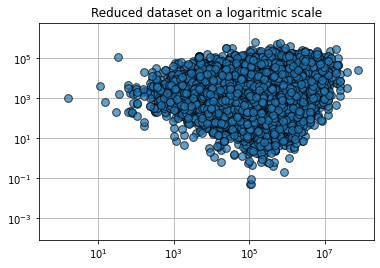

In [109]:
#plt.scatter(red_data[:,0],red_data[:,1],logy=True)

fig, ax = plt.subplots()
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(red_data[:,0],red_data[:,1], s=60, alpha=0.7, edgecolors="k",zorder=3)
plt.title("Reduced dataset on a logaritmic scale")
ax.set_yscale("log")
ax.set_xscale("log")